# Offline Handwriting to Text OCR

In [180]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import inf
image = cv2.imread('Naseer_spaced.jpg')

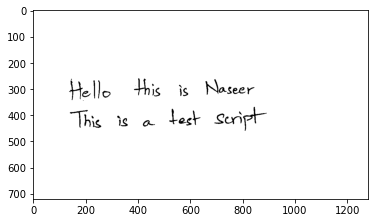

In [181]:
# Convert image to binary 0-1 image using Otsu's threshold
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(img, cmap=plt.get_cmap('binary'))
plt.show()

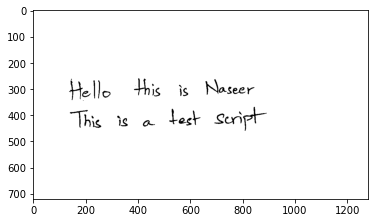

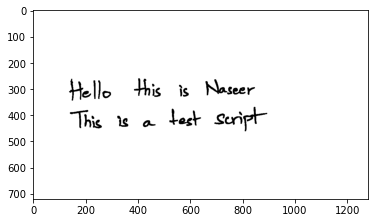

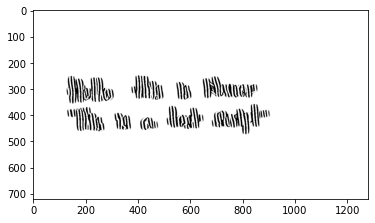

In [182]:
# Remove small noise dots
kernel = np.ones((2, 2), np.uint8)
original_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(img, cmap=plt.get_cmap('binary'))
plt.show()

# Perform dilation to increase the size of the text
kernel = np.ones((3, 3), np.uint8)
img = cv2.dilate(original_img, kernel, iterations=1)
plt.imshow(img, cmap=plt.get_cmap('binary'))
plt.show()

# Apply filter kernel with size=25, sigma=5 and theta=3
kernel = cv2.getGaborKernel((25, 25), 5.0, 3.0, 10.0, 0.5, 0, ktype=cv2.CV_32F)
img = cv2.filter2D(original_img, cv2.CV_8UC3, kernel)
plt.imshow(img, cmap=plt.get_cmap('binary'))
plt.show()

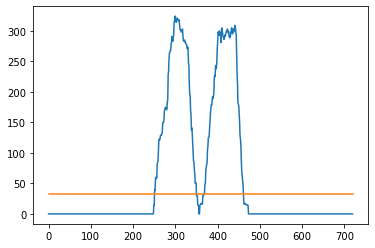

[250, 367]
[349, 461]


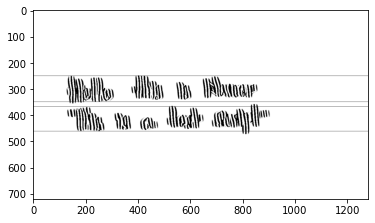

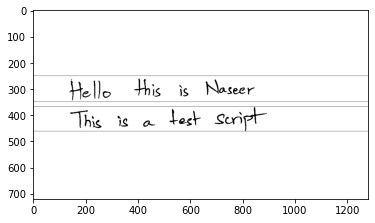

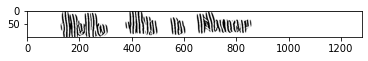

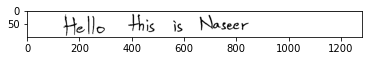

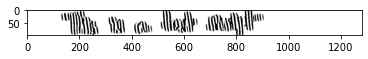

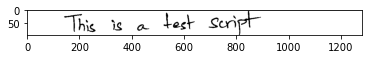

In [183]:
# Perform vertical histogram projection to find the text lines
hist = []
for i in range(img.shape[0]):
    pixels = img[i:i+1,:]
    hist.append((pixels == 0).sum())
hist = max(hist) - hist

# Draw threshold line on the histogram
th = min(hist) + 0.1*(max(hist) - min(hist))
plt.plot(hist)
plt.plot([0, len(hist)], [th, th])
plt.show()

# Find the text lines
H, W = img.shape[:2]
uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

# Match upper with appropriate lower
uppers.append(inf)
matched_upper = []
matched_lower = []
i = 0
j = 0
while i < len(uppers) - 1 and j < len(lowers):
    if uppers[i] > lowers[j]:
        j += 1
    elif uppers[i+1] > lowers[j]:
        matched_upper.append(uppers[i])
        matched_lower.append(lowers[j])
        i += 1
        j += 1
    else:
        j += 1
uppers = matched_upper
lowers = matched_lower

# Discard lines that are too small
min_height = 0.05*H
for i in range(len(uppers)):
    if lowers[i] - uppers[i] < min_height:
        uppers[i] = 0
        lowers[i] = 0
uppers = [uppers[i] for i in range(len(uppers)) if uppers[i] != 0]
lowers = [lowers[i] for i in range(len(lowers)) if lowers[i] != 0]
print(uppers)
print(lowers)

# Draw the text lines
page = img
original_page = original_img
for y in uppers:
    cv2.line(page, (0, y), (W, y), (255, 255, 255), 1)
    cv2.line(original_page, (0, y), (W, y), (255, 255, 255), 1)
for y in lowers:
    cv2.line(page, (0, y), (W, y), (255, 255, 255), 1)
    cv2.line(original_page, (0, y), (W, y), (255, 255, 255), 1)
plt.imshow(page, cmap=plt.get_cmap('binary'))
plt.show()
plt.imshow(original_page, cmap=plt.get_cmap('binary'))
plt.show()

# Extract the text lines
text_lines = []
original_text_lines = []
for i in range(len(uppers)):
    text_lines.append(img[uppers[i]:lowers[i], 0:W])
    original_text_lines.append(original_img[uppers[i]:lowers[i], 0:W])
    plt.imshow(text_lines[i], cmap=plt.get_cmap('binary'))
    plt.show()
    plt.imshow(original_text_lines[i], cmap=plt.get_cmap('binary'))
    plt.show()

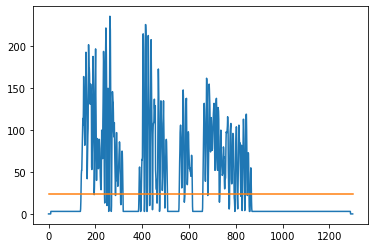

[138, 386, 558, 658]
[317, 507, 614, 866]


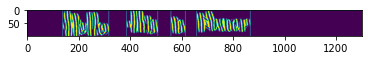

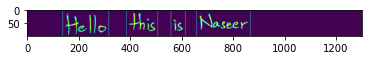

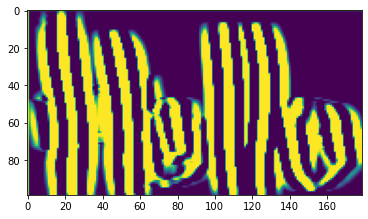

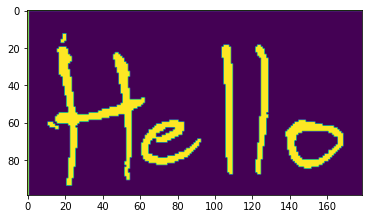

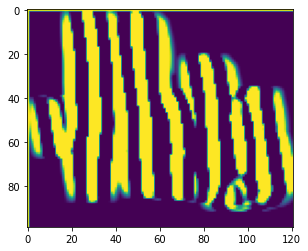

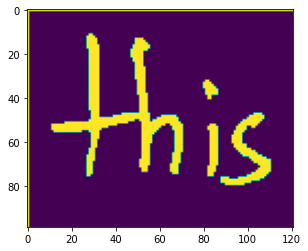

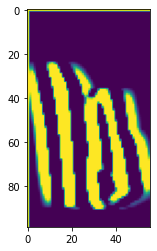

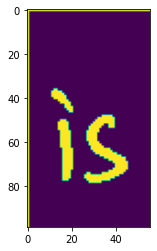

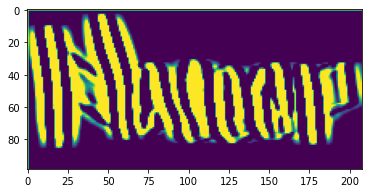

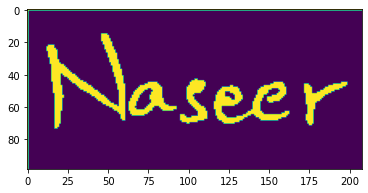

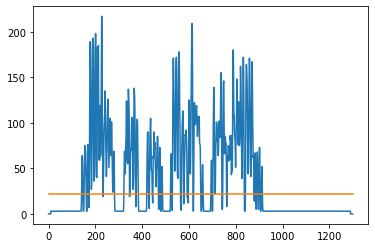

[141, 321, 419, 520, 693]
[281, 383, 486, 660, 913]


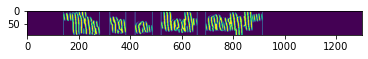

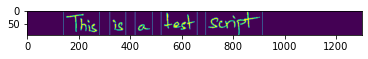

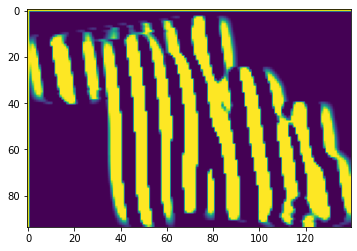

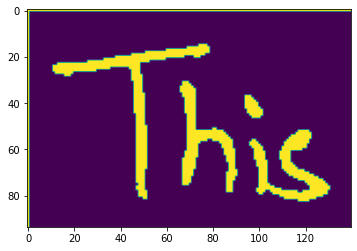

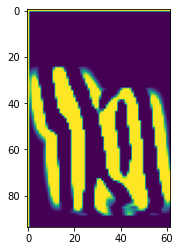

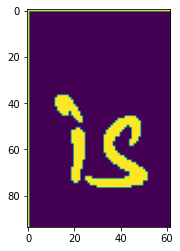

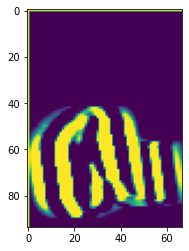

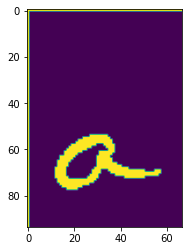

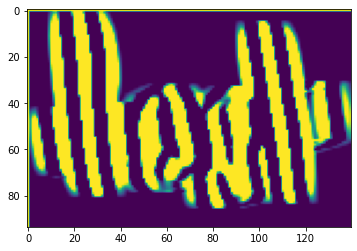

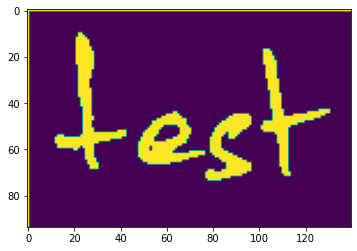

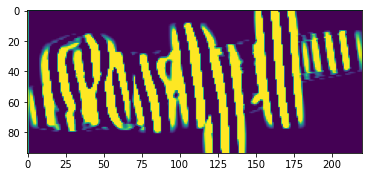

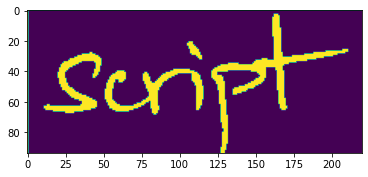

In [184]:
# Draw the words for each text line using horizontal histogram projection
words = []
original_words = []
for i in range(len(text_lines)):
    # Wrap white pixels around the text
    text_lines[i] = cv2.copyMakeBorder(text_lines[i], 0, 0, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    original_text_lines[i] = cv2.copyMakeBorder(original_text_lines[i], 0, 0, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    hist = cv2.reduce(text_lines[i], 0, cv2.REDUCE_AVG).reshape(-1)
    # Draw threshold line on the histogram
    th = min(hist) + 0.1*(max(hist) - min(hist))
    plt.plot(hist)
    plt.plot([0, len(hist)], [th, th])
    plt.show()
    H, W = text_lines[i].shape[:2]
    lefts = [x for x in range(W-1) if hist[x]<=th and hist[x+1]>th]
    rights = [x for x in range(W-1) if hist[x]>th and hist[x+1]<=th]
    # Merge words consecutive words with small gaps using gap statistics
    if len(lefts) > 1:
        gaps = [lefts[j] - rights[j-1] for j in range(1, len(lefts))]
        mean_gap = np.mean(gaps)
        std_gap = np.std(gaps)
        for j in range(1, len(lefts)):
            if abs(gaps[j-1] - mean_gap) < std_gap:
                lefts[j] = 0
                rights[j-1] = 0
        lefts = [x for x in lefts if x != 0]
        rights = [x for x in rights if x != 0]
    print(lefts)
    print(rights)
    # Draw the words
    line = text_lines[i]
    original_line = original_text_lines[i]
    for x in lefts:
        cv2.line(line, (x, 0), (x, H), (255, 255, 255), 1)
        cv2.line(original_line, (x, 0), (x, H), (255, 255, 255), 1)
    for x in rights:
        cv2.line(line, (x, 0), (x, H), (255, 0, 0), 1)
        cv2.line(original_line, (x, 0), (x, H), (255, 0, 0), 1)
    plt.imshow(line)
    plt.show()
    plt.imshow(original_line)
    plt.show()
    # Extract the words
    for j in range(len(lefts)):
        words.append(text_lines[i][0:H, lefts[j]:rights[j]])
        original_words.append(original_text_lines[i][0:H, lefts[j]:rights[j]])
        plt.imshow(words[-1])
        plt.show()
        plt.imshow(original_words[-1])
        plt.show()

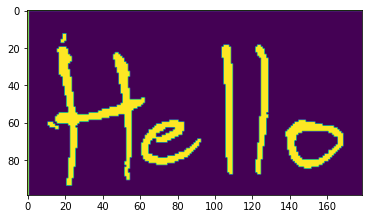

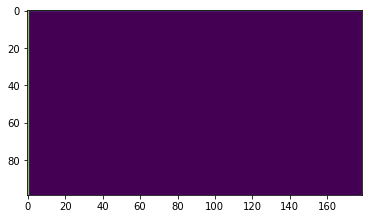

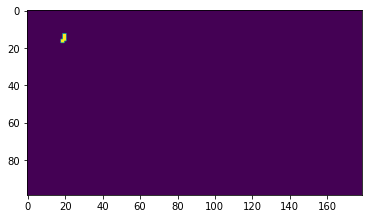

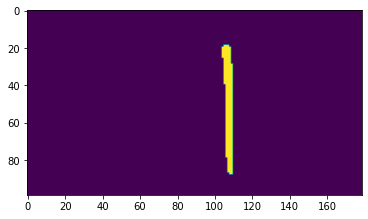

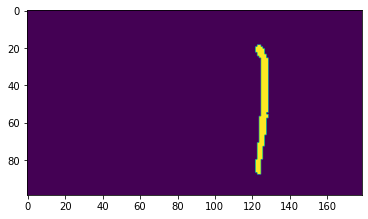

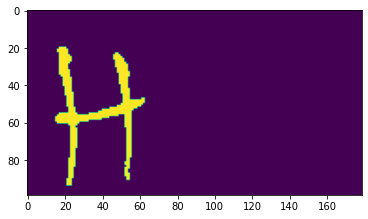

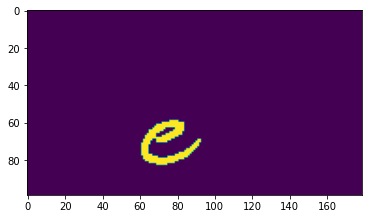

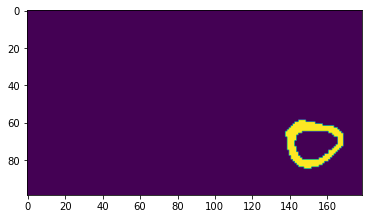

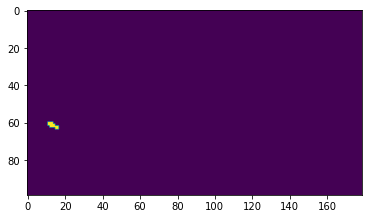

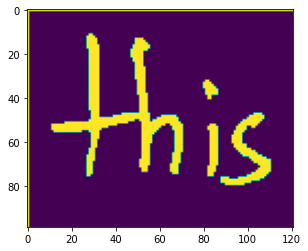

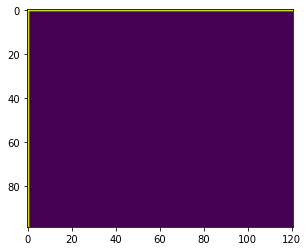

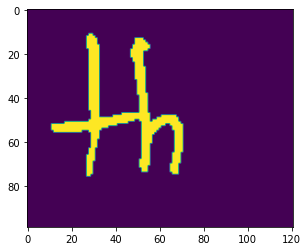

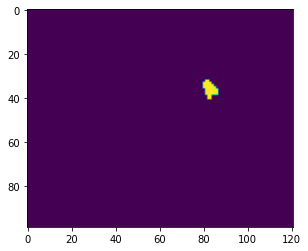

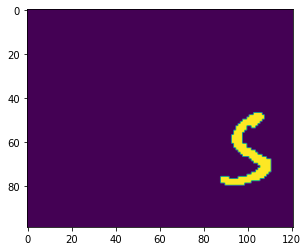

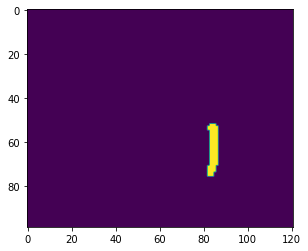

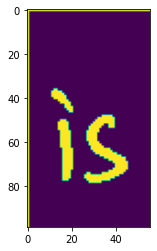

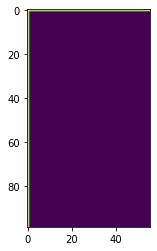

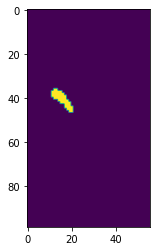

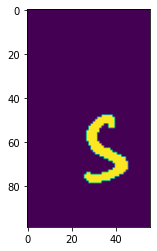

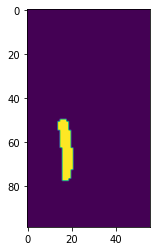

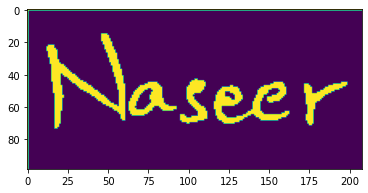

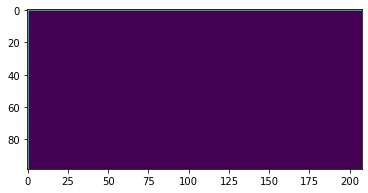

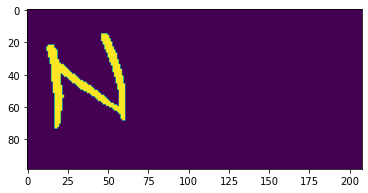

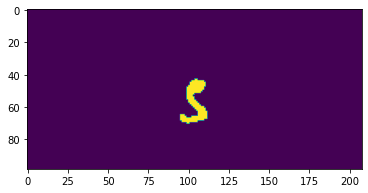

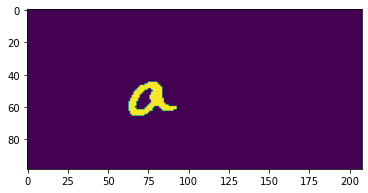

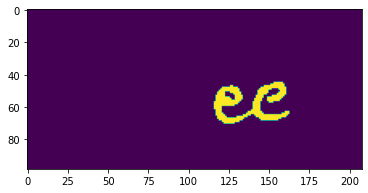

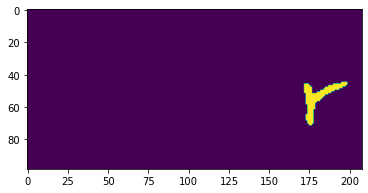

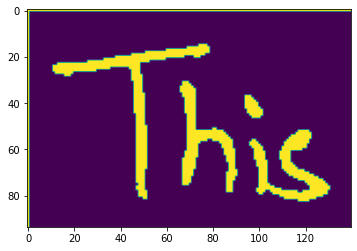

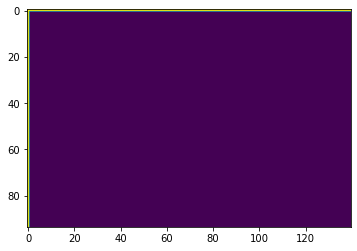

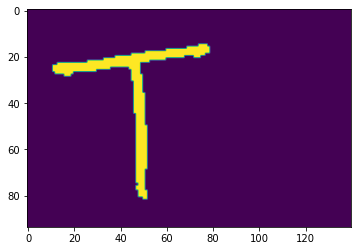

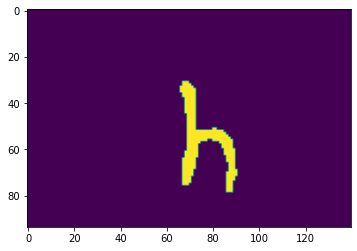

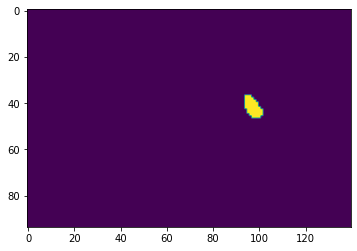

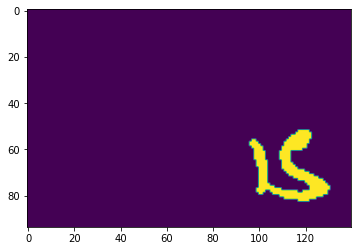

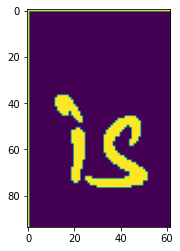

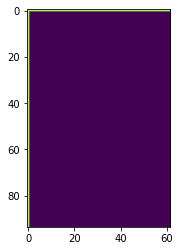

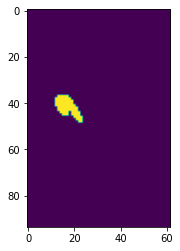

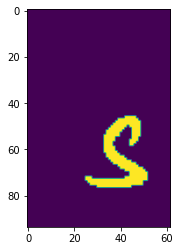

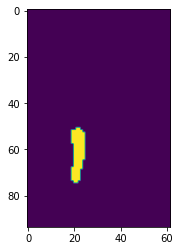

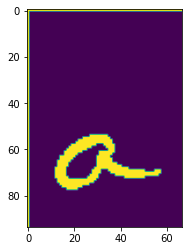

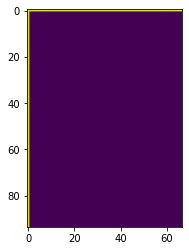

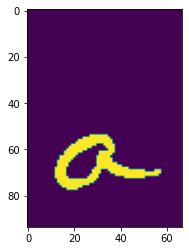

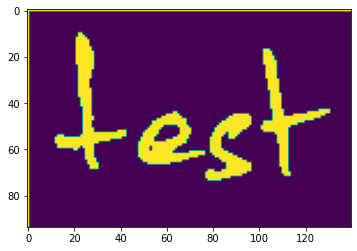

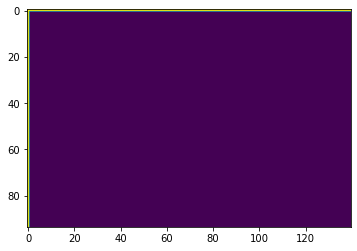

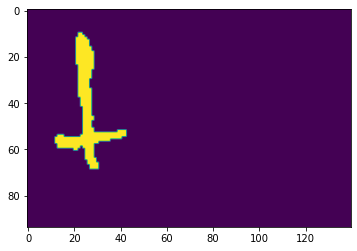

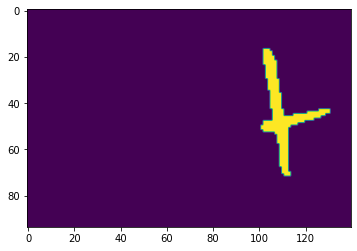

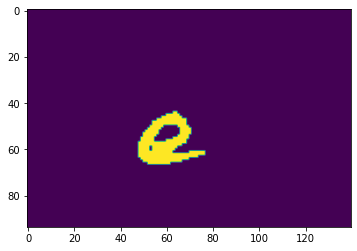

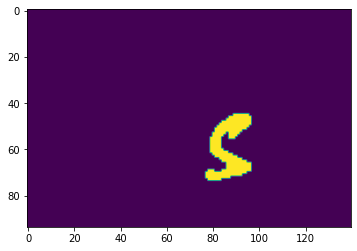

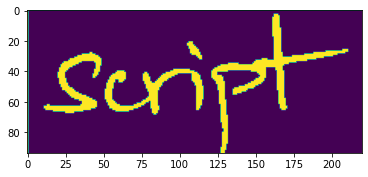

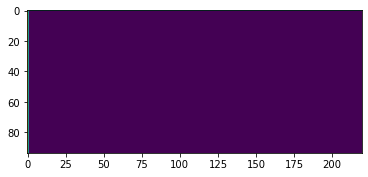

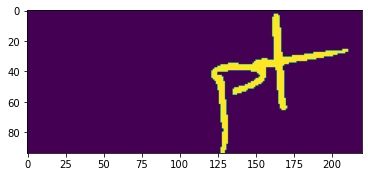

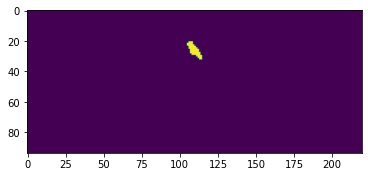

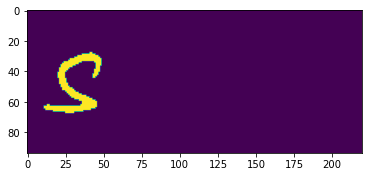

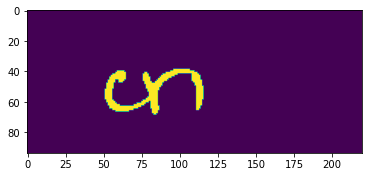

In [185]:
words = original_words
# Thin the words to make pen stroke width 1 pixel
for i in range(len(words)):
    plt.imshow(words[i])
    plt.show()
    characters = []
    # Character segmentation using connected component analysis and bounding box
    ret, labels = cv2.connectedComponents(words[i])
    for j in range(1, ret):
        character = np.zeros(words[i].shape)
        character[labels == j] = 255
        characters.append(character)
        plt.imshow(character)
        plt.show()